# TiREx Demand Forecasting Demo

This notebook demonstrates how to use TiREx for grocery demand forecasting.

In [31]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import duckdb

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cu126
CUDA available: False


In [32]:
# Import TiREx with CPU-only configuration
import sys
import os

# Configure for CPU-only execution
os.environ['PYTORCH_DISABLE_DYNAMO'] = '1'
os.environ['TIREX_NO_CUDA'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from tirex import load_model, ForecastModel
print("✓ TiREx imported successfully")
print("  Using vanilla backend (CPU-only mode)")

✓ TiREx imported successfully
  Using vanilla backend (CPU-only mode)


In [33]:
# Import TiREx with automatic GPU/CPU configuration
import sys
import os

# Configure for CPU-only execution if CUDA is not available
os.environ['PYTORCH_DISABLE_DYNAMO'] = '1'  # Always needed for compatibility

if not torch.cuda.is_available():
    os.environ['TIREX_NO_CUDA'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    print("CUDA not available - configuring for CPU-only execution")
else:
    print("CUDA available - using GPU acceleration")

from tirex import load_model, ForecastModel
print("✓ TiREx imported successfully")

if os.environ.get('TIREX_NO_CUDA') == '1':
    print("  Using vanilla backend (CPU-only mode)")
else:
    print("  Using CUDA backend (GPU acceleration)")

CUDA not available - configuring for CPU-only execution
✓ TiREx imported successfully
  Using vanilla backend (CPU-only mode)


In [34]:
# Get daily sales for the top product
product_id = top_products.iloc[0]['productId']
product_name = top_products.iloc[0]['product_name']

daily_sales = conn.execute(f"""
    SELECT 
        CAST(saleDate AS DATE) as sale_date,
        SUM(quantity) as daily_quantity
    FROM sales
    WHERE productId = '{product_id}'
    GROUP BY CAST(saleDate AS DATE)
    ORDER BY sale_date
""").df()

# Convert to datetime
daily_sales['sale_date'] = pd.to_datetime(daily_sales['sale_date'])

# Create complete date range
date_range = pd.date_range(
    start=daily_sales['sale_date'].min(),
    end=daily_sales['sale_date'].max(),
    freq='D'
)

# Fill missing dates with 0
ts_data = pd.Series(index=date_range, data=0.0)
for _, row in daily_sales.iterrows():
    ts_data[row['sale_date']] = row['daily_quantity']

print(f"Time series for: {product_name}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Total days: {len(ts_data)}")
print(f"Days with sales: {(ts_data > 0).sum()}")

Time series for: Chicken Tikka Filled Naan
Date range: 2023-07-12 00:00:00 to 2025-07-09 00:00:00
Total days: 729
Days with sales: 729


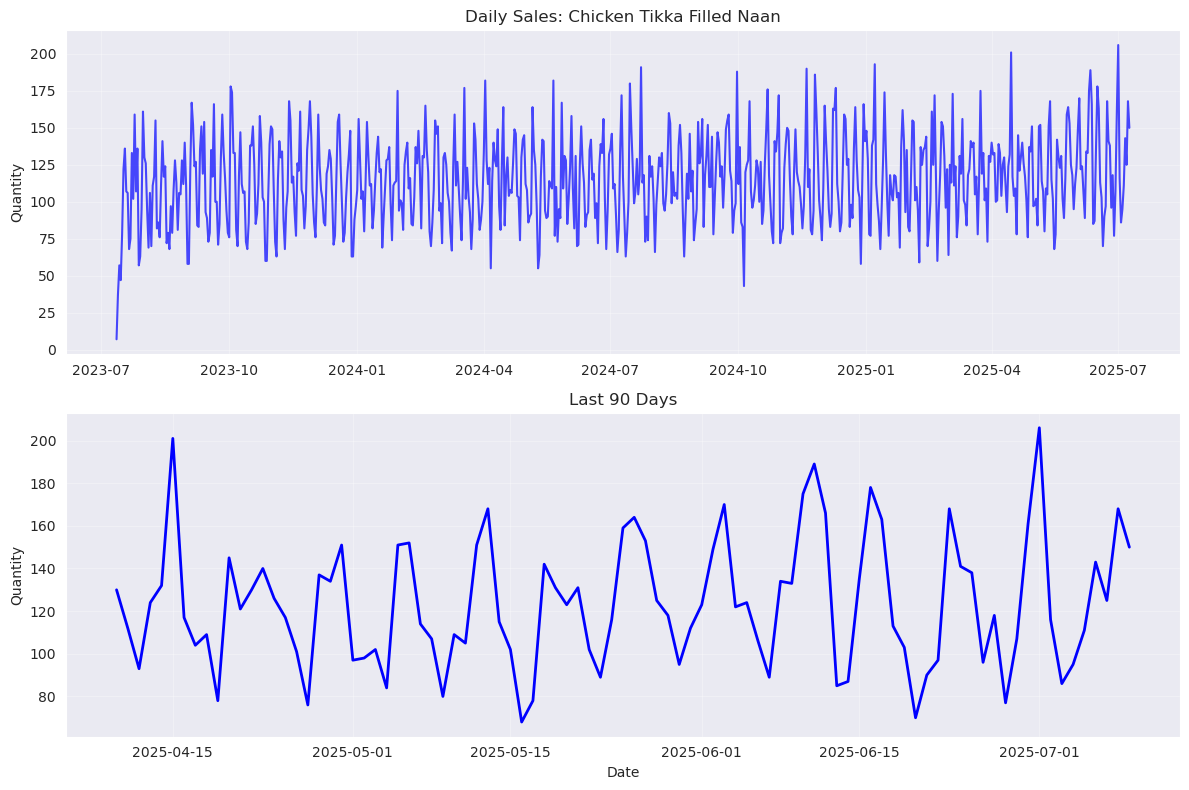

In [35]:
# Visualize the time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Full time series
ax1.plot(ts_data.index, ts_data.values, 'b-', alpha=0.7)
ax1.set_title(f'Daily Sales: {product_name}')
ax1.set_ylabel('Quantity')
ax1.grid(True, alpha=0.3)

# Last 90 days
cutoff_date = ts_data.index[-1] - pd.Timedelta(days=90)
recent_data = ts_data.loc[ts_data.index >= cutoff_date]
ax2.plot(recent_data.index, recent_data.values, 'b-', linewidth=2)
ax2.set_title('Last 90 Days')
ax2.set_xlabel('Date')
ax2.set_ylabel('Quantity')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Load TiREx model with CPU support
print("Loading TiREx model...")

# Force CPU device for loading
device = torch.device('cpu')

try:
    # Load model with explicit CPU device
    model = load_model("NX-AI/TiRex", device=device)
    print("✓ Model loaded successfully")
    print(f"  Running on: {device}")
    print(f"  CUDA available: {torch.cuda.is_available()}")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    print("\nDebugging info:")
    print(f"  PyTorch version: {torch.__version__}")
    print(f"  CUDA available: {torch.cuda.is_available()}")
    print(f"  PYTORCH_DISABLE_DYNAMO: {os.environ.get('PYTORCH_DISABLE_DYNAMO', 'not set')}")
    raise

Loading TiREx model...
✓ Model loaded successfully
  Running on: cpu
  CUDA available: False


/home/abobreshov/miniconda3/envs/grocery_poc/lib/python3.12/site-packages/tirex/models/tirex.py:192: UserWarning: You use TiRex without sLSTM CUDA kernels! This might slow down the model considerably and might degrade forecasting results!Set the environment variable TIREX_NO_CUDA to 0 to avoid this!
  warnings.warn(


In [37]:
# Load TiREx model
print("Loading TiREx model...")
device = torch.device('cpu')
model = load_model("NX-AI/TiRex", device=device)
print("✓ Model loaded successfully on CPU")

Loading TiREx model...
✓ Model loaded successfully on CPU


/home/abobreshov/miniconda3/envs/grocery_poc/lib/python3.12/site-packages/tirex/models/tirex.py:192: UserWarning: You use TiRex without sLSTM CUDA kernels! This might slow down the model considerably and might degrade forecasting results!Set the environment variable TIREX_NO_CUDA to 0 to avoid this!
  warnings.warn(


In [38]:
# Generate forecast
print(f"Generating {prediction_length}-day forecast...")
quantiles, mean = model.forecast(
    context=context_tensor,
    prediction_length=prediction_length,
    output_type="numpy"
)

# Extract results
forecast_mean = mean[0]  # Remove batch dimension
forecast_quantiles = quantiles[0]

print(f"Forecast shape: {forecast_mean.shape}")
print(f"Quantiles shape: {forecast_quantiles.shape}")

Generating 14-day forecast...
Forecast shape: (14,)
Quantiles shape: (14, 9)


In [39]:
# Load TiREx model
print("Loading TiREx model...")

# Use appropriate device based on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model("NX-AI/TiRex", device=device)
print(f"✓ Model loaded successfully on {device}")

Loading TiREx model...
✓ Model loaded successfully on cpu


/home/abobreshov/miniconda3/envs/grocery_poc/lib/python3.12/site-packages/tirex/models/tirex.py:192: UserWarning: You use TiRex without sLSTM CUDA kernels! This might slow down the model considerably and might degrade forecasting results!Set the environment variable TIREX_NO_CUDA to 0 to avoid this!
  warnings.warn(


In [40]:
# Create forecast dates
last_date = ts_data.index[-1]
forecast_dates = pd.date_range(
    start=last_date + timedelta(days=1),
    periods=prediction_length,
    freq='D'
)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'forecast': forecast_mean,
    'lower_bound': forecast_quantiles[:, 0],  # First quantile (lowest)
    'upper_bound': forecast_quantiles[:, -1]  # Last quantile (highest)
})

print("\nForecast Results:")
print(forecast_df)


Forecast Results:
         date    forecast  lower_bound  upper_bound
0  2025-07-10  114.068596    90.061890   148.287750
1  2025-07-11   98.634079    75.415474   131.113480
2  2025-07-12   99.063774    75.991798   131.679916
3  2025-07-13  125.079765    98.436157   162.836807
4  2025-07-14  153.875153   121.229172   195.641357
5  2025-07-15  161.919952   128.685837   200.620514
6  2025-07-16  136.148392   106.236717   174.257584
7  2025-07-17  111.242798    86.518860   146.875793
8  2025-07-18   96.799225    73.482498   129.184814
9  2025-07-19   97.599724    73.817734   129.992889
10 2025-07-20  122.434273    93.248962   160.191223
11 2025-07-21  149.205414   113.565788   188.970261
12 2025-07-22  155.778931   120.180313   196.777710
13 2025-07-23  135.085968   102.394775   173.483047


## 4. Visualize Forecast

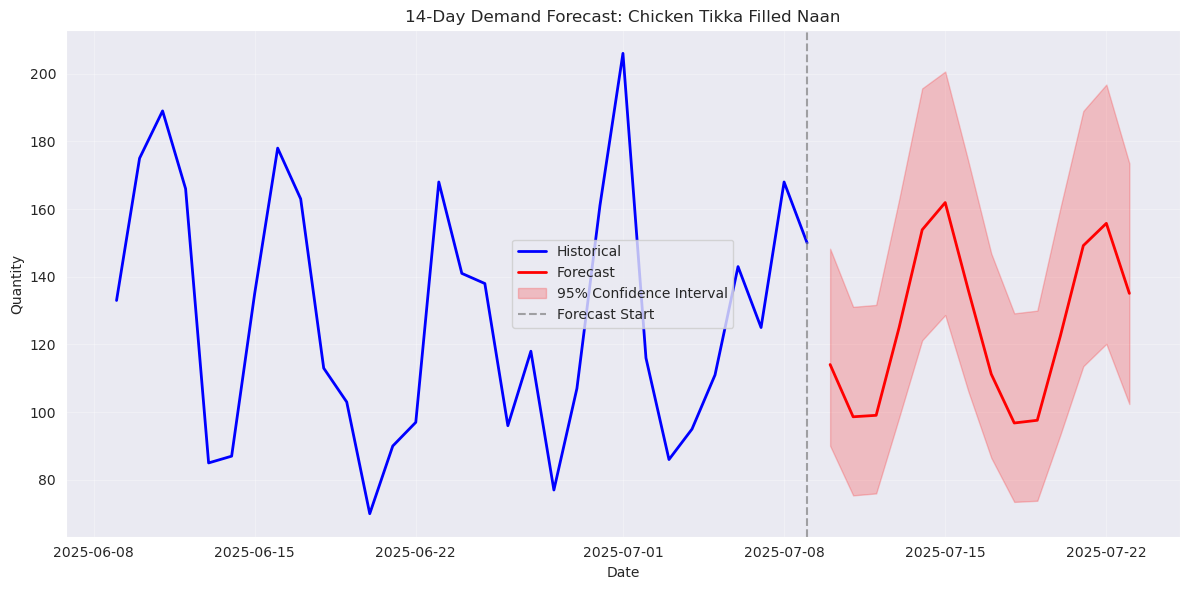

In [41]:
# Visualize forecast with confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))

# Plot historical data (last 30 days)
history_days = 30
cutoff_date = ts_data.index[-1] - pd.Timedelta(days=history_days)
recent_history = ts_data.loc[ts_data.index >= cutoff_date]
ax.plot(recent_history.index, recent_history.values, 'b-', label='Historical', linewidth=2)

# Plot forecast
ax.plot(forecast_df['date'], forecast_df['forecast'], 'r-', label='Forecast', linewidth=2)

# Plot confidence interval
ax.fill_between(
    forecast_df['date'],
    forecast_df['lower_bound'],
    forecast_df['upper_bound'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Formatting
ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
ax.set_title(f'14-Day Demand Forecast: {product_name}')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize forecast with confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))

# Plot historical data (last 30 days)
history_days = 30
cutoff_date = ts_data.index[-1] - pd.Timedelta(days=history_days)
recent_history = ts_data.loc[ts_data.index >= cutoff_date]
ax.plot(recent_history.index, recent_history.values, 'b-', label='Historical', linewidth=2)

# Plot forecast
ax.plot(forecast_df['date'], forecast_df['forecast'], 'r-', label='Forecast', linewidth=2)

# Plot confidence interval
ax.fill_between(
    forecast_df['date'],
    forecast_df['lower_bound'],
    forecast_df['upper_bound'],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Formatting
ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
ax.set_title(f'14-Day Demand Forecast: {product_name}')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Generate batch forecasts
print(f"Generating forecasts for {batch_size} products...")
batch_quantiles, batch_mean = model.forecast(
    context=batch_tensor,
    prediction_length=prediction_length,
    batch_size=batch_size,
    output_type="numpy"
)

print(f"Batch forecast shape: {batch_mean.shape}")

Generating forecasts for 5 products...
Batch forecast shape: (5, 14)


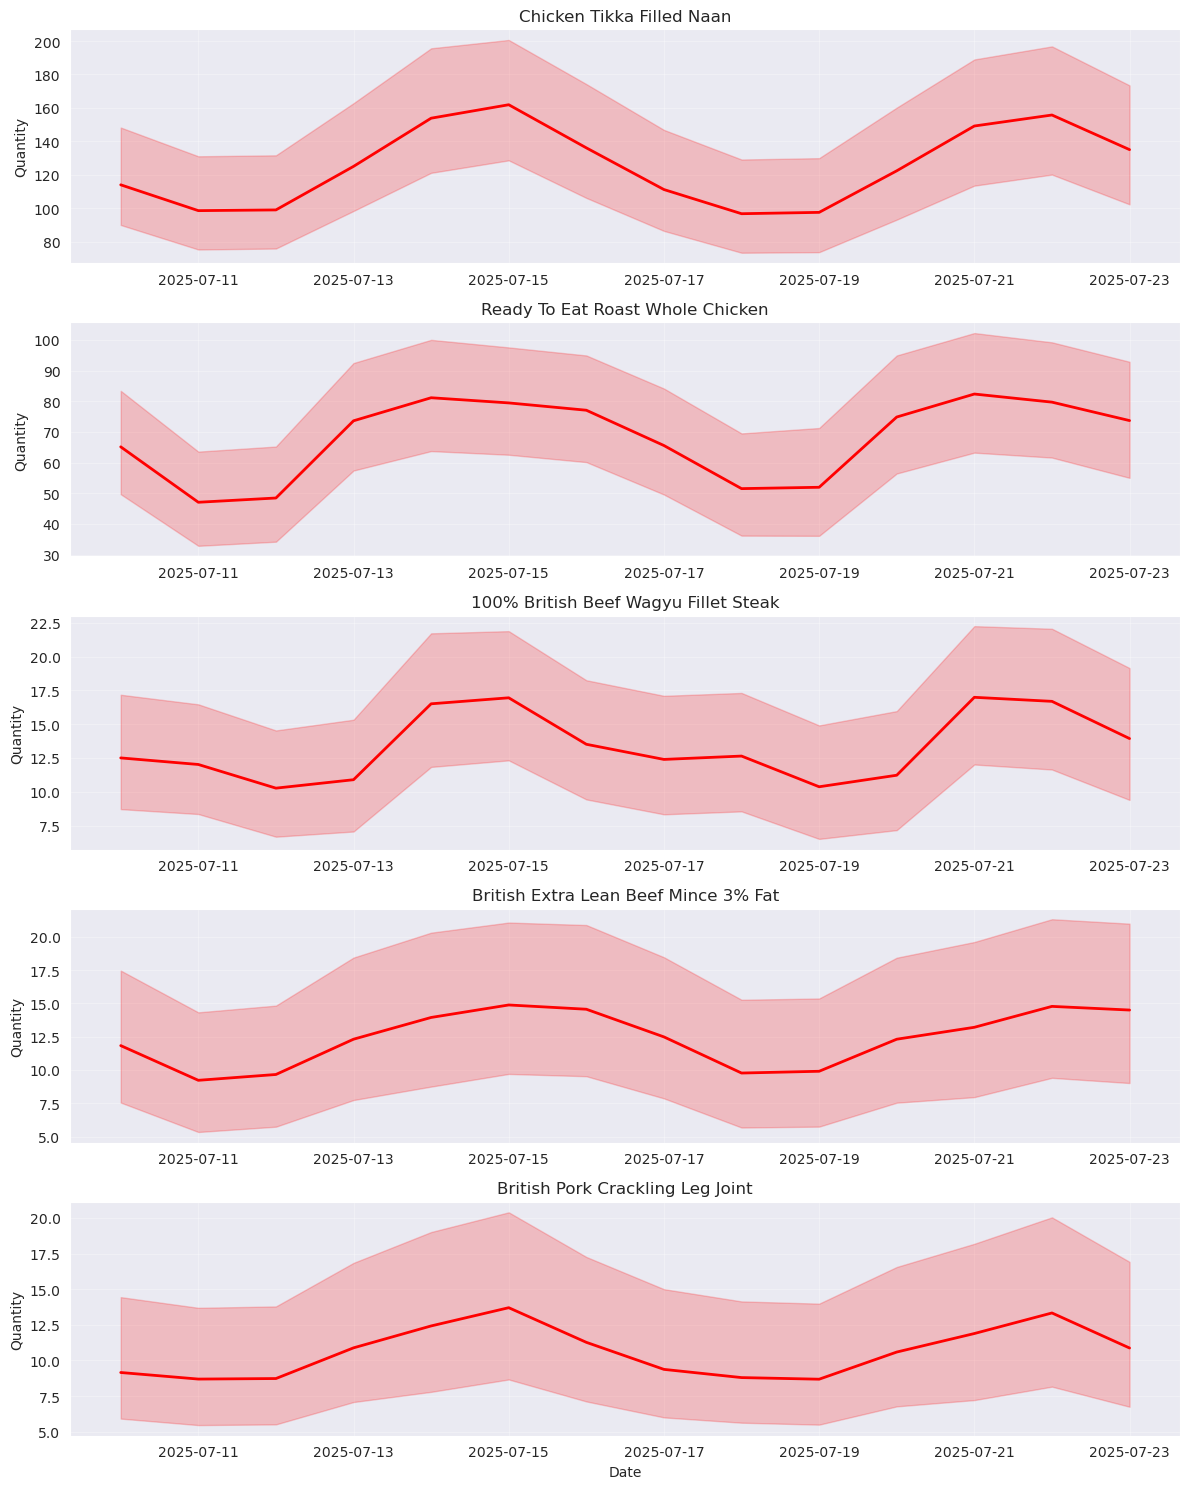

In [28]:
# Visualize batch forecasts
fig, axes = plt.subplots(batch_size, 1, figsize=(12, 3*batch_size))
if batch_size == 1:
    axes = [axes]

for i, (ax, name) in enumerate(zip(axes, product_names)):
    # Plot forecast
    ax.plot(forecast_dates, batch_mean[i], 'r-', linewidth=2)
    ax.fill_between(
        forecast_dates,
        batch_quantiles[i, :, 0],   # First quantile (lowest)
        batch_quantiles[i, :, -1],  # Last quantile (highest)
        color='red',
        alpha=0.2
    )
    
    ax.set_title(f'{name}')
    ax.set_ylabel('Quantity')
    ax.grid(True, alpha=0.3)
    
    if i == len(axes) - 1:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

## 6. Save Forecasts to Database

In [15]:
# Example: Save the batch forecasts
import uuid

# Create forecast records
forecast_records = []
run_id = str(uuid.uuid4())

for i, (pid, name) in enumerate(zip(product_ids[:batch_size], product_names[:batch_size])):
    for h in range(prediction_length):
        forecast_records.append({
            'forecast_id': str(uuid.uuid4()),
            'run_id': run_id,
            'productId': pid,
            'product_name': name,
            'forecast_date': last_date.date(),
            'target_date': (last_date + timedelta(days=h+1)).date(),
            'forecast_horizon': h + 1,
            'predicted_quantity': float(batch_mean[i, h]),
            'confidence_lower': float(batch_quantiles[i, h, 0]),  # Fixed indexing
            'confidence_upper': float(batch_quantiles[i, h, -1])  # Fixed indexing
        })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_records)
print(f"\nGenerated {len(forecast_df)} forecast records")
print("\nSample records:")
print(forecast_df.head())


Generated 70 forecast records

Sample records:
                            forecast_id                                run_id  \
0  b0084329-6f95-400d-b213-1564b2f57474  29b8ed22-35b5-4d44-af02-fd9088e029a9   
1  e216901c-d4ad-4508-9308-5fffd850f427  29b8ed22-35b5-4d44-af02-fd9088e029a9   
2  e5f24e1a-1583-40f0-8e12-d0aae70ed88c  29b8ed22-35b5-4d44-af02-fd9088e029a9   
3  a0d26b26-8aea-49bd-9486-78bdc2a6aa6c  29b8ed22-35b5-4d44-af02-fd9088e029a9   
4  c7aa5415-8992-45ac-9bb7-0ef392436274  29b8ed22-35b5-4d44-af02-fd9088e029a9   

            productId               product_name forecast_date target_date  \
0  000000000631972003  Chicken Tikka Filled Naan    2025-07-09  2025-07-10   
1  000000000631972003  Chicken Tikka Filled Naan    2025-07-09  2025-07-11   
2  000000000631972003  Chicken Tikka Filled Naan    2025-07-09  2025-07-12   
3  000000000631972003  Chicken Tikka Filled Naan    2025-07-09  2025-07-13   
4  000000000631972003  Chicken Tikka Filled Naan    2025-07-09  2025-07-14 

## Summary

This notebook demonstrated:
1. Loading grocery sales data from DuckDB
2. Preparing time series data for TiREx
3. Using TiREx for single product forecasting
4. Batch forecasting for multiple products
5. Visualizing forecasts with confidence intervals

Next steps:
- Run full backtesting on historical data
- Calculate accuracy metrics
- Generate production forecasts for all products